In [1]:
from collections import Counter
import os,re,string,json
from tqdm import tqdm
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import nltk
from matplotlib.dates import date2num
import matplotlib.dates as mdates

from functions import *

plotting.style_()

tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures"]} for k,v in tf_science.items()}

In [2]:
def load_clean(iso='gb',start_month='2020-01',end_month='2020-12',text_version='lemmatized'):
    df = data_loader.load_month(iso,start_month,end_month)
    df['text'] = [utils.preprocess(str(x)) for x in df[text_version]]
    return df 

def add_metadata(df,iso='gb',house=True,date_format='week'):
    if house == True:
        if iso != 'gb':
            df['house'] = ['upper' if 'upper' in x else 'lower' for x in df['term']]
        if iso == 'gb':
            df['house'] = ['upper' if 'lords' in x else 'lower' for x in df['id']]
    if date_format == 'week':
        df['week'] = [df['from'][c][:4] + '-' + str(datetime.strptime(x, '%Y-%m-%d').isocalendar()[1]) for c,x in enumerate(df['from'])]
        df['week'] = [x.replace('-','-0') if len(x) == 6 else x for x in df['week']]
    if date_format == 'month':
        df['month'] = [x[:7] for x in df['from']]
    if date_format == 'day':
        df['day'] = df['from']
    return df

def get_totals(df,date_format='week',house=True):
    if house == True:
        tt = {}
        tt['upper'] = {w:len(" ".join(list(df[(df[date_format] == w) & (df['house'] == 'upper')]['text'])).split(' ')) for w in set(df[date_format])}
        tt['lower'] = {w:len(" ".join(list(df[(df[date_format] == w) & (df['house'] == 'lower')]['text'])).split(' ')) for w in set(df[date_format])}
    else:
        tt = {w:len(" ".join(list(df[(df[date_format] == w)]['text'])).split(' ')) for w in set(df[date_format])}
    return tt

In [3]:
def plot_words(iso='gb',start='2020-01',end='2020-08',terms=[],date_format='week',fill_blanks=True):
    df = load_clean(iso,start,end)
    df = add_metadata(df,iso,house=False,date_format=date_format)
    totals = get_totals(df,date_format=date_format,house=False)
    freqdata = df.copy()
    for term in terms:
        freqdata[term + '_hits'] = [len([w for w in t.split(' ') if w == term]) for t in df['text']]
    
    hit_cols = [term + '_hits' for term in terms]
    freqdata = freqdata[[date_format] + hit_cols]
    freqdata = freqdata.groupby(date_format).sum().reset_index()
    for c in list(freqdata.columns)[1:]:
        freqdata[c] = [int(x) / int(totals[freqdata[date_format][co]]) for co,x in enumerate(freqdata[c])]

    if fill_blanks == True:
        d1 = freqdata[date_format].min()
        d2 = freqdata[date_format].max()
        missing_dates = [[d] + [None for x in hit_cols] for d in utils.date_generator(date_format,d1,d2) if d not in list(freqdata[date_format])] 
        freqdata = freqdata.append(pd.DataFrame(missing_dates,columns=freqdata.columns))
    freqdata.columns = [date_format,'n']
    return freqdata.sort_values(date_format).reset_index(drop=True)

In [11]:
freqdata = pd.DataFrame()

for i in ["gb","nl","dk","it","cz","pl","es","lt"]:
    print(i)
    fd = plot_words(iso=i,start='2019-10',end='2020-08',terms=[tf_science[i]['expert']],date_format='week',fill_blanks=True)
    fd['l'] = i 
    freqdata = freqdata.append(fd)

gb
nl
dk
it
cz
pl
es
lt


In [12]:
freqdata = freqdata.pivot(index='week',columns='l',values='n').reset_index()
freqdata = freqdata.fillna(0.0)

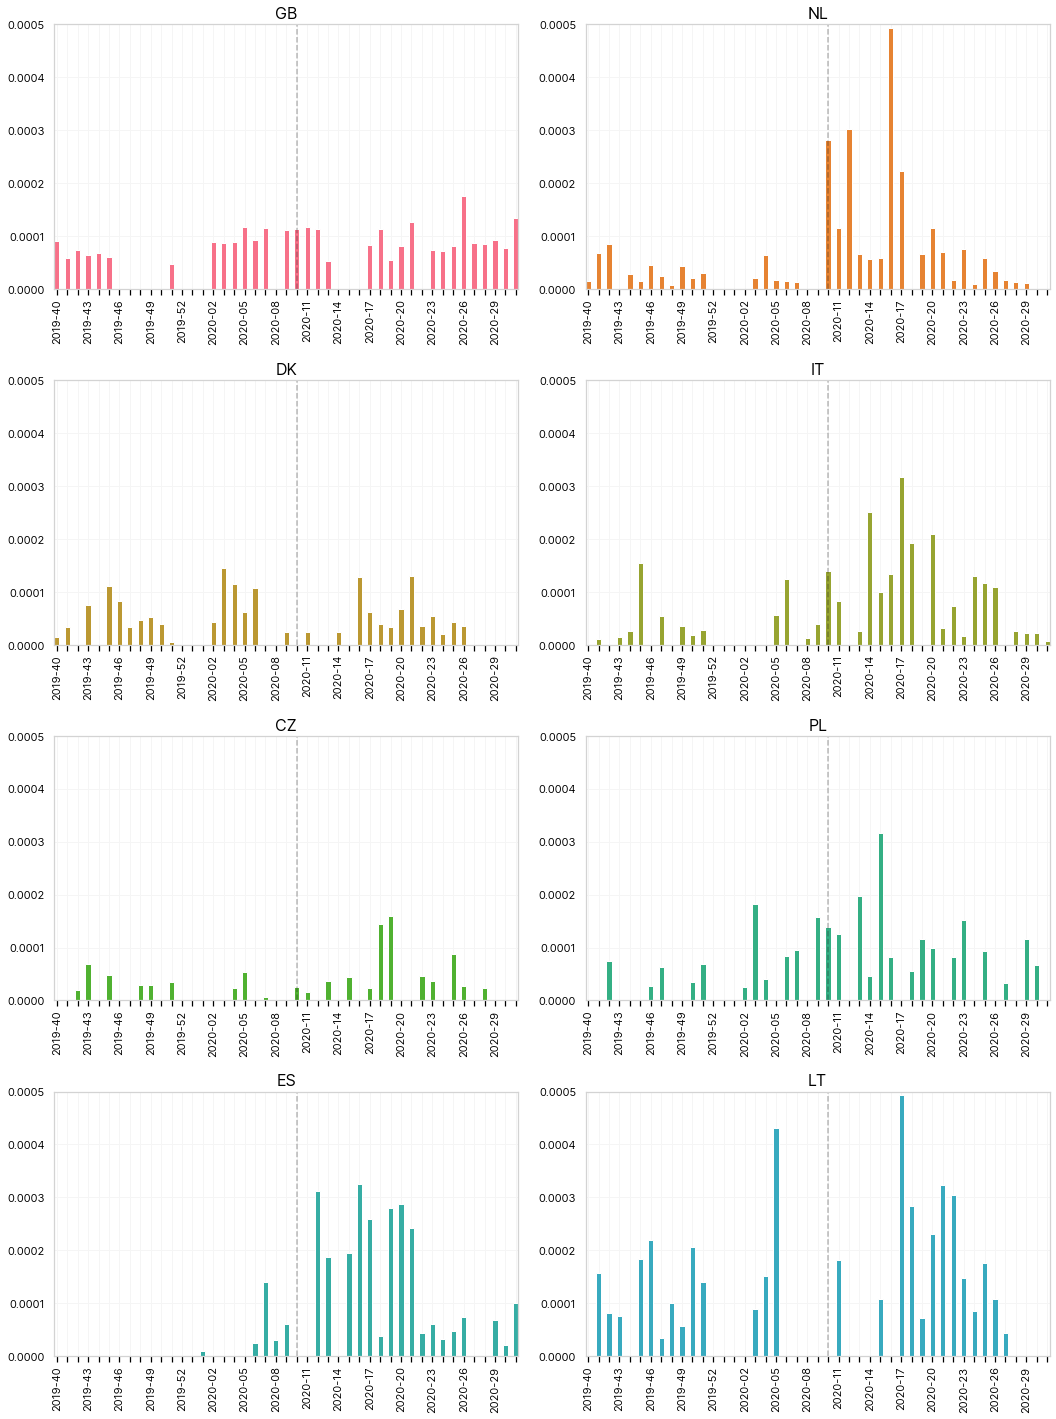

In [22]:
fig,ax = plt.subplots(4,2,figsize=(15,20))
colors = sns.color_palette("husl", 12) #["teal","salmon","blue","red","brown","darkslategray","red","teal"]

for c,l in enumerate(["gb","nl","dk","it","cz","pl","es","lt"]):
    ax.reshape(-1)[c].bar(freqdata['week'],freqdata[l],color=colors[c],width=0.5)
    ax.reshape(-1)[c].title.set_text(l.upper())
    ax.reshape(-1)[c].axvline(x=23, color='k', linestyle='--', alpha=0.3)
plt.setp(ax, ylim=(0,0.0005))

for ax_ in ax.reshape(-1):
    for label in ax_.get_xticklabels():
        label.set_rotation(90) 
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

for ax_ in ax.reshape(-1):
    for n, label in enumerate(ax_.xaxis.get_ticklabels()):
        if n % 3 != 0:
            label.set_visible(False)

plt.savefig('/home/ruben/Documents/GitHub/ParlaMintCase/results/plots/frequencies/expert-relfreq-gbnldkitczpleslt.png',dpi=300,bbox_inches='tight')

In [8]:
# Horizontal bar chart

def get_coal_opp(iso,terms):
    date_format = 'month'
    df = load_clean(iso,'2020-03','2020-08')
    df = add_metadata(df,iso,house=False,date_format='month')
    
    freqdata = df.copy()
    for term in terms:
        freqdata[term + '_hits'] = [len([w for w in t.split(' ') if w == tf_science[iso]['expert']]) for t in df['text']]

    hit_cols = [term + '_hits' for term in terms]
    if iso == 'gb':
        freqdata['coalition'] = ["coalition" if "CON" in str(x) else "opposition" for x in freqdata['speaker_party']]  
    else:
        freqdata['coalition'] = freqdata['party_status']

    total_coalition = len(" ".join(freqdata[freqdata['coalition'] == 'coalition']['lemmatized'].astype(str)))
    total_opposition = len(" ".join(freqdata[freqdata['coalition'] == 'opposition']['lemmatized'].astype(str)))

    df = freqdata[hit_cols + ['coalition']].groupby('coalition').sum().T
    df = df[['coalition','opposition']]
    df['coalition_r'] = [x / total_coalition for x in df['coalition']]
    df['opposition_r'] = [x / total_coalition for x in df['opposition']]

    df['iso'] = iso 
    return df.reset_index(drop=True)

In [55]:
d = pd.DataFrame()

for iso in ["gb","nl","dk","it","cz","pl","es","lt"]:
    try:
        print(iso)
        t = get_coal_opp(iso,[tf_science[iso]['expert']])
        d = d.append(t)
    except Exception as e:
        print(iso,e)
        continue

d['ratio'] = d['coalition'] / d['opposition']

gb
nl
dk
dk "['opposition'] not in index"
it
cz
pl
es
lt


In [64]:
d

coalition,coalition,opposition,coalition_r,opposition_r,iso,ratio
0,325,342,0.000017,0.000017,gb,0.950292
0,155,94,0.000015,0.000009,nl,1.648936
0,39,54,0.000011,0.000015,it,0.722222
0,14,47,0.000006,0.000021,cz,0.297872
0,24,93,0.000008,0.000032,pl,0.258065
0,89,91,0.000028,0.000029,es,0.978022
0,75,72,0.000034,0.000033,lt,1.041667


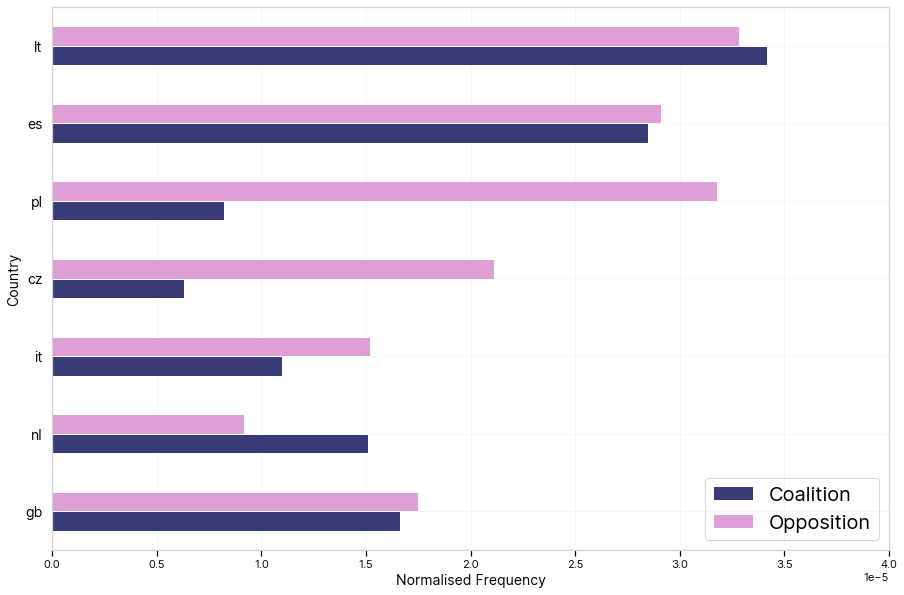

In [63]:
fig,ax = plt.subplots(1,1,figsize=(15,20))
the_plot = d.plot.barh(x='iso',y=['coalition_r','opposition_r'],figsize=(15,10),ax=ax,cmap='tab20b')
plt.xlabel('Normalised Frequency')
plt.ylabel('Country')
plt.xlim(0,0.00004)
plt.legend(['Coalition','Opposition'],title='',fontsize=20)
plt.yticks(fontsize=14)

plt.savefig('/home/ruben/Documents/GitHub/ParlaMintCase/results/plots/frequencies/expert-relfreq-coalition-gbnldkitczpleslt.png',dpi=300,bbox_inches='tight')

In [86]:
# Horizontal bar chart

def get_top_speaker(iso,term):
    df = load_clean(iso,'2020-03','2020-08')
    df = add_metadata(df,iso,house=False,date_format='month')
    
    freqdata = df.copy()
    freqdata[term + '_hits'] = [len([w for w in t.split(' ') if w == tf_science[iso]['expert']]) for t in df['text']]

    hit_cols = term + '_hits'

    df = freqdata[[hit_cols] + ['speaker_party','speaker_name']].groupby(['speaker_party','speaker_name']).sum().reset_index()
    df = df.sort_values(term + "_hits",ascending=False).reset_index(drop=True)
    df = df.iloc[:10,:]
    df['iso'] = iso 
    return df.reset_index(drop=True)

In [100]:
speaker_res = pd.DataFrame()

for iso in ["gb","nl","dk","it","cz","pl","es","lt"]:
    df = load_clean(iso,'2020-03','2020-08')
    df = add_metadata(df,iso,house=False,date_format='month')
    
    freqdata = df.copy()
    freqdata[tf_science[iso]['expert'] + '_hits'] = [len([w for w in t.split(' ') if w == tf_science[iso]['expert']]) for t in df['text']]

    hit_cols = tf_science[iso]['expert'] + '_hits'

    df = freqdata[[hit_cols] + ['speaker_party','speaker_name']].groupby(['speaker_party','speaker_name']).sum().reset_index()
    df = df.sort_values(tf_science[iso]['expert'] + "_hits",ascending=False).reset_index(drop=True)
    df = df.iloc[:10,:]
    df['iso'] = iso 
    t = df
    t['speaker_name'] = [f"{i} ({t['speaker_party'][c]})" for c,i in enumerate(t['speaker_name'])]
    speaker_res[iso.upper()] = t['speaker_name']
    speaker_res[iso.upper() + " freq."] = t[hit_cols]

In [102]:
speaker_res.to_csv('/home/ruben/Documents/GitHub/ParlaMintCase/results/tables/top-speakers-expert.csv',index=False)

In [4]:
nds = pd.DataFrame() 
for iso in ["gb","nl","dk","it","cz","pl","es","lt"]:
    freqdata = load_clean(iso,'2019-10','2020-08')
    freqdata = add_metadata(freqdata,iso,house=False,date_format='month')

    freqdata[tf_science[iso]['expert'] + '_hits'] = [len([w for w in t.split(' ') if w == tf_science[iso]['expert']]) for t in freqdata['text']]

    hit_cols = tf_science[iso]['expert'] + '_hits'
    freqdata['month'] = [x[:7] for x in freqdata['from']]
    bu = freqdata
    tt = freqdata[['month','speaker_name']].groupby('month').nunique().to_dict()['speaker_name']
    freqdata = freqdata[freqdata[hit_cols] != 0]
    freqdata = freqdata["month speaker_name".split(' ') + [hit_cols]].groupby(['month','speaker_name']).sum().reset_index()
    freqdata.columns = ['month','name','n']
    freqdata = freqdata.groupby('month').size().reset_index()
    freqdata['iso'] = iso
    freqdata.columns = ['month','n','iso']
    freqdata['n'] = [i / tt[freqdata['month'][c]] for c,i in enumerate(freqdata['n'])]
    nds = nds.append(freqdata)

In [5]:
nds.columns = ['m','l','iso']
nds = nds.pivot(index='m',values='l',columns='iso')

/home/ruben/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


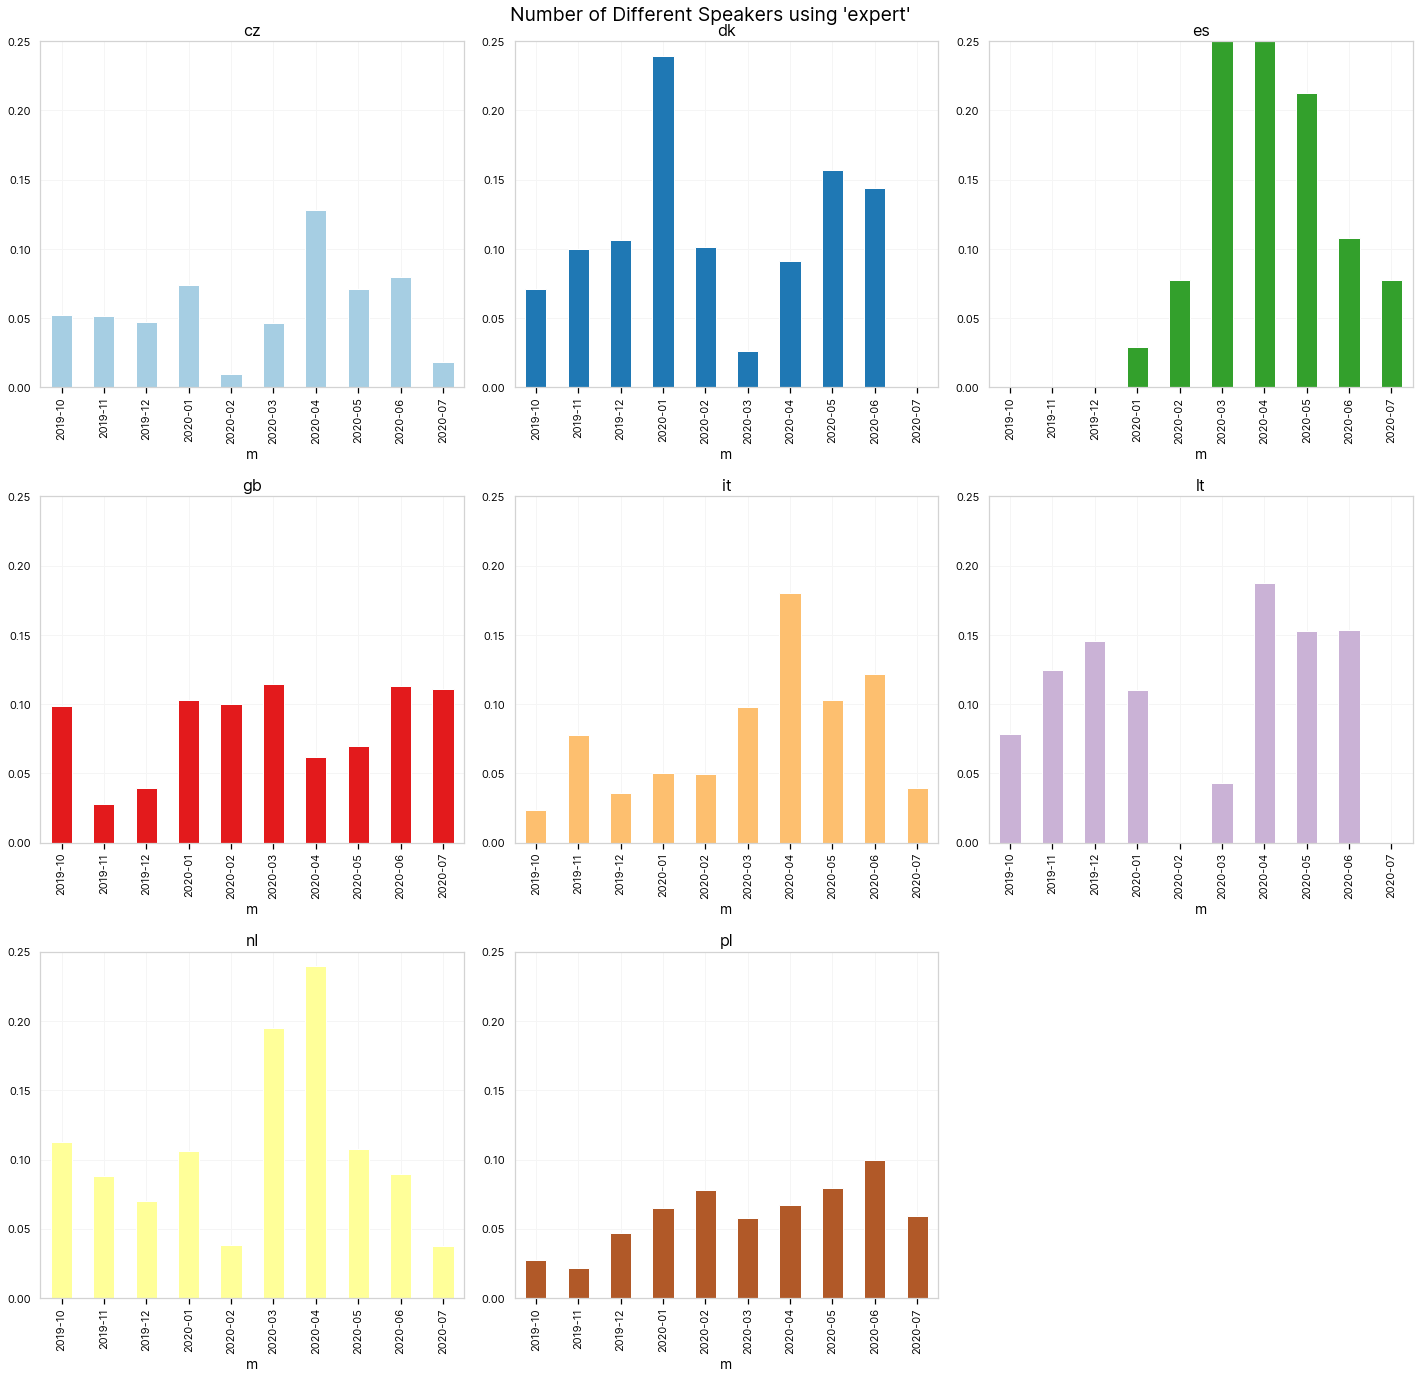

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,25))
nds.plot(kind='bar', subplots=True, grid=True, title="Number of Different Speakers using 'expert'",
        layout=(4, 3),legend=False,cmap='Paired',ax=ax,ylim=(0,0.25))


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig('/home/ruben/Documents/GitHub/ParlaMintCase/results/plots/frequencies/expert-relnumspeakers.png',dpi=300,bbox_inches='tight')
plt.show()